<a href="https://colab.research.google.com/github/JieShenAI/net/blob/main/basic/weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U numpy

     |████████████████████████████████| 15.7 MB 29.6 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [52]:
import  torch
import  torch.nn as nn
import  torch.nn.functional as F
import  torch.optim as optim
from  torchvision import datasets, transforms

In [53]:
import os
import numpy as np
import pandas as pd

#读取csv文件下的所有文件
root_ = 'drive/MyDrive/kaggle/demo/csv/'
files= [root_+i for i in os.listdir('drive/MyDrive/kaggle/demo/csv') if '.ipynb' not in i]

使用pandas进行表的拼接

In [ ]:
def merge_csv(input_list,outputfile):
  """
  将传入input_list列表内的csv文件，合并成一个csv文件，输出到outputfile
  """
  flag = False
  for inputfile in input_list:
    if flag is False:
      pd_ = pd.read_csv(inputfile) #header=None表示原始文件数据没有列索引，这样的话read_csv会自动加上列索引
      flag = True
      # 第一次，覆盖原来的文件的内容
      pd_.to_csv(outputfile, index=False, header=True)
      continue
    else:
      pd_ = pd.read_csv(inputfile)
    pd_.to_csv(outputfile, mode='a', index=False, header=False) #header=0表示不保留列名，index=False表示不保留行索引，mode='a'表示附加方式写入，文件原有内容不会被清除

In [ ]:
out_csv = 'drive/MyDrive/kaggle/demo/out/all.csv'
# 将文件合并到out/all.csv
merge_csv(files,out_csv)
pd_ = pd.read_csv(out_csv)

In [ ]:
pd_.shape

(3970, 5)

根据月份给每行数据设置上不同的季节：
春天：0，夏天：1，秋天：2，冬天：3

In [ ]:
def set_season(input_file,output_path):
  
  pd_ = pd.read_csv(input_file)
  season_dataframe = []
  for i in pd_['日期']:
    if '星期' in i:
      d = i.strip().split()[:-1:][0]
      m = int(d.split('-')[1])
    else:
      # 2011年的日期，不带有星期
      m = int(i.split('-')[1])
    
    # 春季：3月、4月、5月；夏季：6月、7月、8月，秋季：9月、10月、11月；冬季：12月、1月、2月；
    if 3<=m<=5:
      season_ = 0
    elif 6<=m<=8:
      season_ = 1
    elif 9<=m<=11:
      season_ = 2
    elif m==12 or 1<=m<=2:
      season_ = 3
    season_dataframe.append(season_)
  pd_['季节'] = season_dataframe
  pd_.to_csv(output_path,index=False)

In [ ]:
set_season('drive/MyDrive/kaggle/demo/out/all.csv','drive/MyDrive/kaggle/demo/out/season.csv')
# 带有季节的csv文件路径
season_path = 'drive/MyDrive/kaggle/demo/out/season.csv'

# 数据清洗

## 把最高气温和最低气温的度的字符串去掉(22℃ -> 22)

In [ ]:
pd_ = pd.read_csv(season_path)
high_ = pd_['最高气温']  
pd_['最高气温'] = [h[:-1:] for h in high_]
low_ = pd_['最低气温']
pd_['最低气温'] = [l[:-1:] for l in low_] 

In [ ]:
pd_

,日期,最高气温,最低气温,天气,风向,季节
0,2011-01-01,0,-3,中雪~小雪,北风~无持续风向 3-4级~微风,3
1,2011-01-02,2,-2,阴,无持续风向 微风,3
2,2011-01-03,2,0,小雪,无持续风向 微风,3
3,2011-01-04,5,-1,阴,无持续风向 微风,3
4,2011-01-05,7,-2,多云,无持续风向 微风,3
...,...,...,...,...,...,...
3965,2021-11-22 星期一,11,2,多云,东北风 1级,2
3966,2021-11-23 星期二,15,2,晴,南风 2级,2
3967,2021-11-24 星期三,18,3,晴,南风 2级,2
3968,2021-11-25 星期四,20,4,晴,东风 1级,2


## 删除日期

## 将天气和风向进行one_hot编码

In [ ]:
weather = pd.get_dummies(pd_['天气'],drop_first=True)
wind = pd.get_dummies(pd_['风向'],drop_first=True)
pd_ = pd.concat([pd_,weather,wind],axis=1)
pd_.head()

,日期,最高气温,最低气温,天气,风向,季节,中雨~多云,中雨~大雨,中雨~小雨,中雨~晴,中雨~暴雨,中雨~阴,中雨到大雨,中雨转多云,中雨转大雨,中雨转小雨,中雨转暴雨,中雨转阴,中雨转阵雨,中雨转雨,中雪,中雪~小雪,中雪转小雪,多云,多云~,多云~中雨,多云~小雨,多云~晴,多云~阴,多云~阵雨,多云~雷阵雨,多云转中雨,多云转多云,多云转小雨,多云转晴,多云转阴,多云转阵雨,多云转雨,多云转雨夹雪,多云转雪,...,北风 4级,北风 5级,北风 小于3级,北风 微风,北风~微风 3-4级~小于3级,北风~微风 4-5级~小于3级,北风~无持续风向 3-4级~微风,南风 0级,南风 1级,南风 2级,南风 3-4级,南风 3级,南风 4级,南风 微风,微风 小于3级,微风 微风,微风~东北风 小于3级,微风~东北风 小于3级~3-4级,微风~东南风 小于3级~3-4级,微风~北风 小于3级~3-4级,微风~北风 小于3级~4-5级,微风~南风 小于3级~3-4级,无持续风向 小于3级,无持续风向 微风,无持续风向~北风 微风~3-4级,无持续风向~北风 微风~4-5级,暂无实况,西北风 1级,西北风 2级,西北风 3级,西北风 微风,西北风~西风 小于3级,西南风 1级,西南风 2级,西南风 3级,西南风 4级,西风 1级,西风 2级,西风 3级,西风 微风
0,2011-01-01,0,-3,中雪~小雪,北风~无持续风向 3-4级~微风,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2011-01-02,2,-2,阴,无持续风向 微风,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2011-01-03,2,0,小雪,无持续风向 微风,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2011-01-04,5,-1,阴,无持续风向 微风,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2011-01-05,7,-2,多云,无持续风向 微风,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


删除多余元素

In [ ]:
pd_.drop('日期',axis=1,inplace=True)
pd_.drop('天气',axis=1,inplace=True)
pd_.drop('风向',axis=1,inplace=True)
pd_

KeyError: ignored

In [ ]:
pd_.shape

(3970, 221)

将pd_中的str转成int

In [ ]:
# df['DataFrame Column'] = df['DataFrame Column'].astype(int)
pd_['最高气温'] = pd_['最高气温'].astype(int)
pd_['最低气温'] = pd_['最低气温'].astype(int)
'''
# 验证完毕，字符串已全部转为int
header = pd_.columns
for h in header:
  print(type(pd_.loc[0,h]))
'''

In [ ]:
pd_.to_csv('drive/MyDrive/kaggle/demo/out/end.csv',index=False)

## shuffle（下一次启动入口）

In [ ]:
from sklearn.utils import shuffle
pd_ = pd.read_csv('drive/MyDrive/kaggle/demo/out/end.csv')
pd_ = shuffle(pd_)

In [ ]:
pd_

,最高气温,最低气温,季节,中雨~多云,中雨~大雨,中雨~小雨,中雨~晴,中雨~暴雨,中雨~阴,中雨到大雨,中雨转多云,中雨转大雨,中雨转小雨,中雨转暴雨,中雨转阴,中雨转阵雨,中雨转雨,中雪,中雪~小雪,中雪转小雪,多云,多云~,多云~中雨,多云~小雨,多云~晴,多云~阴,多云~阵雨,多云~雷阵雨,多云转中雨,多云转多云,多云转小雨,多云转晴,多云转阴,多云转阵雨,多云转雨,多云转雨夹雪,多云转雪,多云转雷阵雨,大雨,大雨~中雨,...,北风 4级,北风 5级,北风 小于3级,北风 微风,北风~微风 3-4级~小于3级,北风~微风 4-5级~小于3级,北风~无持续风向 3-4级~微风,南风 0级,南风 1级,南风 2级,南风 3-4级,南风 3级,南风 4级,南风 微风,微风 小于3级,微风 微风,微风~东北风 小于3级,微风~东北风 小于3级~3-4级,微风~东南风 小于3级~3-4级,微风~北风 小于3级~3-4级,微风~北风 小于3级~4-5级,微风~南风 小于3级~3-4级,无持续风向 小于3级,无持续风向 微风,无持续风向~北风 微风~3-4级,无持续风向~北风 微风~4-5级,暂无实况,西北风 1级,西北风 2级,西北风 3级,西北风 微风,西北风~西风 小于3级,西南风 1级,西南风 2级,西南风 3级,西南风 4级,西风 1级,西风 2级,西风 3级,西风 微风
2402,29,24,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3445,27,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3657,15,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1076,20,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1288,34,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,20,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2535,14,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2914,4,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2231,7,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 抽取验证集、测试集

对于小规模样本集（几万量级），常用的分配比例是60% 训练集、20% 验证集、20% 测试集

In [ ]:
train_len = int(0.8*len(pd_))
val_len = int(0.1*len(pd_))
test_len = len(pd_)-train_len-val_len

In [ ]:
train_len,val_len,test_len

(3176, 397, 397)

## 训练集、验证集、测试集

### 训练集

In [ ]:
train_dataset = pd_[:train_len:]
train_label_ = train_dataset['季节'][:train_len:]
# 抽取完label，删掉原数据中的label属性

In [ ]:
train_label_

2402    1
3445    0
3657    3
1076    3
1288    1
       ..
2491    2
3759    0
3119    1
526     1
688     3
Name: 季节, Length: 3176, dtype: int64

In [ ]:
# 后续进行了one-hot编码，再回来对比
train_label

NameError: ignored

### 验证集

In [ ]:
val_dataset = pd_[train_len:train_len+val_len:]
val_label_ = val_dataset['季节']

### 测试集

In [ ]:
test_dataset = pd_[train_len+val_len::]
test_label_ = test_dataset['季节']

### label one-hot编码

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def one_hot(labels):
  '''
  将1D列表进行one-hot编码
  '''
  labels = np.array(labels)
  labels = labels.reshape(-1,1) # 必须执行，不然报错
  one_hot_encoder = OneHotEncoder()
  labels_onehot = one_hot_encoder.fit_transform(labels)
  return torch.FloatTensor(labels_onehot.toarray())

train_label = one_hot(train_label_)
val_label = one_hot(val_label_)
test_label = one_hot(test_label_)

In [ ]:
print(train_label)

tensor([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]])


删除原来的标签

In [ ]:
train_dataset.drop('季节',axis=1,inplace=True)
val_dataset.drop('季节',axis=1,inplace=True)
test_dataset.drop('季节',axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train_dataset.shape,val_dataset.shape,test_dataset.shape

((3176, 220), (397, 220), (397, 220))

## 正则化

In [ ]:
from sklearn.preprocessing import StandardScaler
# 引入标准化
Scaler1 = StandardScaler()
Scaler2 = StandardScaler()
Scaler3 = StandardScaler()
train_dataset = pd.DataFrame(Scaler1.fit_transform(train_dataset)) # 里面的labels已经被标准化了无法使用了
val_dataset  = pd.DataFrame(Scaler2.fit_transform(val_dataset))
test_dataset = pd.DataFrame(Scaler3.fit_transform(test_dataset))

In [ ]:
train_dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219
0,0.746911,1.140760,-0.030749,-0.050252,-0.064109,-0.017747,-0.035511,-0.025102,-0.017747,-0.025102,-0.043506,-0.064109,-0.025102,-0.017747,-0.025102,-0.025102,-0.025102,-0.025102,-0.017747,-0.690803,-0.025102,-0.030749,-0.071157,-0.099282,-0.104025,-0.058953,-0.039709,-0.043506,-0.017747,-0.100887,-0.163813,-0.1115,-0.094311,-0.083518,-0.017747,-0.017747,-0.025102,-0.068886,-0.017747,-0.039709,...,-0.112938,-0.035511,-0.017747,5.994183,-0.058953,-0.025102,-0.053309,-0.025102,-0.092597,-0.159714,-0.046999,-0.1115,-0.035511,-0.030749,-0.766294,-0.025102,-0.030749,-0.030749,-0.025102,-0.061585,-0.035511,-0.039709,-0.025102,-0.33821,-0.050252,0.0,-0.025102,-0.085409,-0.112938,-0.046999,-0.030749,0.0,-0.081585,-0.12518,-0.081585,-0.039709,-0.089073,-0.102467,-0.050252,-0.017747
1,0.532029,0.711527,-0.030749,-0.050252,-0.064109,-0.017747,-0.035511,-0.025102,-0.017747,-0.025102,-0.043506,-0.064109,-0.025102,-0.017747,-0.025102,-0.025102,-0.025102,-0.025102,-0.017747,1.447590,-0.025102,-0.030749,-0.071157,-0.099282,-0.104025,-0.058953,-0.039709,-0.043506,-0.017747,-0.100887,-0.163813,-0.1115,-0.094311,-0.083518,-0.017747,-0.017747,-0.025102,-0.068886,-0.017747,-0.039709,...,-0.112938,-0.035511,-0.017747,-0.166828,-0.058953,-0.025102,-0.053309,-0.025102,-0.092597,-0.159714,-0.046999,-0.1115,-0.035511,-0.030749,-0.766294,-0.025102,-0.030749,-0.030749,-0.025102,-0.061585,-0.035511,-0.039709,-0.025102,-0.33821,-0.050252,0.0,-0.025102,-0.085409,-0.112938,-0.046999,-0.030749,0.0,-0.081585,-0.12518,-0.081585,-0.039709,-0.089073,-0.102467,-0.050252,-0.017747
2,-0.757263,-1.327334,-0.030749,-0.050252,-0.064109,-0.017747,-0.035511,-0.025102,-0.017747,-0.025102,-0.043506,-0.064109,-0.025102,-0.017747,-0.025102,-0.025102,-0.025102,-0.025102,-0.017747,1.447590,-0.025102,-0.030749,-0.071157,-0.099282,-0.104025,-0.058953,-0.039709,-0.043506,-0.017747,-0.100887,-0.163813,-0.1115,-0.094311,-0.083518,-0.017747,-0.017747,-0.025102,-0.068886,-0.017747,-0.039709,...,-0.112938,-0.035511,-0.017747,-0.166828,-0.058953,-0.025102,-0.053309,-0.025102,-0.092597,-0.159714,-0.046999,-0.1115,-0.035511,-0.030749,-0.766294,-0.025102,-0.030749,-0.030749,-0.025102,-0.061585,-0.035511,-0.039709,-0.025102,-0.33821,-0.050252,0.0,-0.025102,-0.085409,-0.112938,-0.046999,-0.030749,0.0,-0.081585,-0.12518,-0.081585,-0.039709,-0.089073,-0.102467,-0.050252,-0.017747
3,-0.220058,-1.112717,-0.030749,-0.050252,-0.064109,-0.017747,-0.035511,-0.025102,-0.017747,-0.025102,-0.043506,-0.064109,-0.025102,-0.017747,-0.025102,-0.025102,-0.025102,-0.025102,-0.017747,-0.690803,-0.025102,-0.030749,-0.071157,-0.099282,-0.104025,-0.058953,-0.039709,-0.043506,-0.017747,-0.100887,-0.163813,-0.1115,-0.094311,-0.083518,-0.017747,-0.017747,-0.025102,-0.068886,-0.017747,-0.039709,...,-0.112938,-0.035511,-0.017747,-0.166828,-0.058953,-0.025102,-0.053309,-0.025102,-0.092597,-0.159714,-0.046999,-0.1115,-0.035511,-0.030749,1.304982,-0.025102,-0.030749,-0.030749,-0.025102,-0.061585,-0.035511,-0.039709,-0.025102,-0.33821,-0.050252,0.0,-0.025102,-0.085409,-0.112938,-0.046999,-0.030749,0.0,-0.081585,-0.12518,-0.081585,-0.039709,-0.089073,-0.102467,-0.050252,-0.017747
4,1.284116,1.462686,-0.030749,-0.050252,-0.064109,-0.017747,-0.035511,-0.025102,-0.017747,-0.025102,-0.043506,-0.064109,-0.025102,-0.017747,-0.025102,-0.025102,-0.025102,-0.025102,-0.017747,-0.690803,-0.025102,-0.030749,-0.071157,-0.099282,-0.104025,-0.058953,-0.039709,-0.043506,-0.017747,-0.100887,-0.163813,-0.1115,10.603234,-0.083518,-0.017747,-0.017747,-0.025102,-0.068886,-0.017747,-0.039709,...,-0.112938,-0.035511,-0.017747,-0.166828,-0.058953,-0.025102,-0.053309,-0.025102,-0.092597,-0.159714,-0.046999,-0.1115,-0.035511,-0.030749,-0.766294,-0.025102,-0.030749,-0.030749,-

# 神经网络模型

In [ ]:
class Weather(nn.Module):

    def __init__(self):
        super(Weather, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(220, 200),
            nn.LeakyReLU(inplace=True),
            nn.Linear(200, 200),
            nn.LeakyReLU(inplace=True),
            nn.Linear(200, 4),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
# 用GPU训练数据
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Weather().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01)
criteon = nn.CrossEntropyLoss().to(device)

## 开始训练

In [ ]:
train_label

tensor([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]])

In [ ]:
train_dataset.loc[10:15,::]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219
10,1.404691,1.581038,-0.028989,-0.05429,-0.061585,0.0,-0.035511,-0.028989,0.0,-0.028989,-0.050252,-0.074078,-0.028989,0.0,-0.028989,-0.020494,0.0,-0.020494,-0.020494,-0.691135,-0.028989,-0.035511,-0.071157,-0.107075,-0.102989,-0.050252,-0.045864,-0.041013,0.0,-0.107075,-0.155163,-0.125612,-0.092018,-0.08967,-0.020494,0.0,0.0,-0.061585,0.0,-0.045864,...,-0.105051,-0.035511,-0.020494,-0.172718,-0.05805,-0.020494,-0.05429,-0.020494,-0.082234,-0.163475,-0.045864,-0.105051,-0.020494,-0.028989,1.311174,-0.028989,-0.035511,-0.035511,-0.020494,-0.074078,-0.035511,-0.035511,0.0,-0.322973,-0.045864,0.0,0.0,-0.08967,-0.116692,-0.041013,-0.028989,0.0,-0.076891,-0.120335,-0.084783,-0.020494,-0.096551,-0.111017,-0.050252,-0.020494
11,0.974921,1.259027,-0.028989,-0.05429,-0.061585,0.0,-0.035511,-0.028989,0.0,-0.028989,-0.050252,-0.074078,-0.028989,0.0,-0.028989,-0.020494,0.0,-0.020494,-0.020494,-0.691135,-0.028989,-0.035511,-0.071157,-0.107075,-0.102989,-0.050252,-0.045864,-0.041013,0.0,-0.107075,-0.155163,-0.125612,-0.092018,-0.08967,-0.020494,0.0,0.0,-0.061585,0.0,-0.045864,...,-0.105051,-0.035511,-0.020494,-0.172718,-0.05805,-0.020494,-0.05429,-0.020494,-0.082234,-0.163475,-0.045864,-0.105051,-0.020494,-0.028989,1.311174,-0.028989,-0.035511,-0.035511,-0.020494,-0.074078,-0.035511,-0.035511,0.0,-0.322973,-0.045864,0.0,0.0,-0.08967,-0.116692,-0.041013,-0.028989,0.0,-0.076891,-0.120335,-0.084783,-0.020494,-0.096551,-0.111017,-0.050252,-0.020494
12,-1.066486,-1.317066,-0.028989,-0.05429,-0.061585,0.0,-0.035511,-0.028989,0.0,-0.028989,-0.050252,-0.074078,-0.028989,0.0,-0.028989,-0.020494,0.0,-0.020494,-0.020494,-0.691135,-0.028989,-0.035511,-0.071157,-0.107075,-0.102989,-0.050252,-0.045864,-0.041013,0.0,-0.107075,-0.155163,-0.125612,-0.092018,-0.08967,-0.020494,0.0,0.0,-0.061585,0.0,-0.045864,...,-0.105051,-0.035511,-0.020494,-0.172718,-0.05805,-0.020494,-0.05429,-0.020494,-0.082234,-0.163475,-0.045864,-0.105051,-0.020494,-0.028989,1.311174,-0.028989,-0.035511,-0.035511,-0.020494,-0.074078,-0.035511,-0.035511,0.0,-0.322973,-0.045864,0.0,0.0,-0.08967,-0.116692,-0.041013,-0.028989,0.0,-0.076891,-0.120335,-0.084783,-0.020494,-0.096551,-0.111017,-0.050252,-0.020494
13,0.974921,0.507666,-0.028989,-0.05429,-0.061585,0.0,-0.035511,-0.028989,0.0,-0.028989,-0.050252,-0.074078,-0.028989,0.0,-0.028989,-0.020494,0.0,-0.020494,-0.020494,-0.691135,-0.028989,-0.035511,-0.071157,-0.107075,-0.102989,-0.050252,-0.045864,-0.041013,0.0,-0.107075,-0.155163,-0.125612,-0.092018,-0.08967,-0.020494,0.0,0.0,-0.061585,0.0,-0.045864,...,-0.105051,-0.035511,-0.020494,-0.172718,-0.05805,-0.020494,-0.05429,-0.020494,-0.082234,-0.163475,-0.045864,-0.105051,-0.020494,-0.028989,-0.762675,-0.028989,-0.035511,-0.035511,-0.020494,-0.074078,-0.035511,-0.035511,0.0,-0.322973,-0.045864,0.0,0.0,-0.08967,-0.116692,-0.041013,-0.028989,0.0,13.005493,-0.120335,-0.084783,-0.020494,-0.096551,-0.111017,-0.050252,-0.020494
14,-0.421831,0.185655,-0.028989,-0.05429,-0.061585,0.0,-0.035511,-0.028989,0.0,-0.028989,-0.050252,-0.074078,-0.028989,0.0,-0.028989,-0.020494,0.0,-0.020494,-0.020494,-0.691135,-0.028989,-0.035511,-0.071157,-0.107075,-0.102989,-0.050252,-0.045864,-0.041013,0.0,-0.107075,-0.155163,-0.125612,-0.092018,-0.08967,-0.020494,0.0,0.0,16.237816,0.0,-0.045864,...,-0.105051,-0.035511,-0.020494,-0.172718,-0.05805,-0.020494,-0.05429,-0.020494,-0.082234,-0.163475,-0.045864,-0.105051,-0.020494,-0.028989,-0.762675,-0.028989,-0.035511,-0.035511,-0.020494,-0.074078,-0.035511,-0.035511,0.0,-0.322973,-0.045864,0.0,0.0,-0.08967,-0.116692,-0.041013,-0.028989,0.0,-0.076891,-0.120335,-0.084783,-0.020494,-0.096551,-0.111017,-0.050252,-0.020494
15,-1.496256,-0.673043,-0.028989,-0.05429,-0.061585,0.0,-0.035511,-0.028989,0.0,-0.02

In [ ]:
torch.FloatTensor(train_dataset[10:15:].values)

tensor([[ 1.4047,  1.5810, -0.0290,  ..., -0.1110, -0.0503, -0.0205],
        [ 0.9749,  1.2590, -0.0290,  ..., -0.1110, -0.0503, -0.0205],
        [-1.0665, -1.3171, -0.0290,  ..., -0.1110, -0.0503, -0.0205],
        [ 0.9749,  0.5077, -0.0290,  ..., -0.1110, -0.0503, -0.0205],
        [-0.4218,  0.1857, -0.0290,  ..., -0.1110, -0.0503, -0.0205]])

In [ ]:
a = torch.FloatTensor(train_dataset.loc[0,::]).reshape(-1,220)
print(train_dataset.shape)
print(a.shape)
# .reshape(-1,220)

(2382, 220)
torch.Size([1, 220])


In [ ]:
epochs = 200
batch_size = 64
batch_num_train = int(len(train_dataset)//batch_size)
batch_num_val = int(len(val_dataset)//batch_size)
batch_num_test = int(len(test_dataset)//batch_size)

In [ ]:
for epoch in range(epochs):
  train_loss = 0
  for i in range(batch_num_train+1):
    start = i * batch_size
    end   = start + batch_size
    logits = net(torch.FloatTensor(train_dataset[start:end:].values))
    loss = criteon(logits, torch.FloatTensor(train_label[start:end:]))
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # 每跑完一个epoch
  val_loss = 0
  correct = 0

  for i in range(batch_num_val+1):
    start = i * batch_size
    end   = start + batch_size
    logits = net(torch.FloatTensor(val_dataset[start:end:].values))
    val_loss += criteon(logits, torch.FloatTensor(val_label[start:end:])).item()
    pred = logits.argmax(dim=1)
    tmp = torch.FloatTensor(val_label[start:end:]).argmax(dim=1)
    correct_ = pred.eq(tmp).sum()
    correct += correct_

    # 不确定是否能取到最大值
    #pred = logits.data.max(1)[1]
    # print(pred,logits.data)
    #correct += pred.eq(val_label.data).sum()
  
  if epoch % 5 == 0:
    print("val_loss:",val_loss)

    print('\nVAL set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_label),
        100. * correct / len(val_label)))

val_loss: 16.79741507768631

VAL set: Average loss: 16.7974, Accuracy: 557/794 (70%)

val_loss: 16.92421555519104

VAL set: Average loss: 16.9242, Accuracy: 557/794 (70%)

val_loss: 17.053700864315033

VAL set: Average loss: 17.0537, Accuracy: 555/794 (70%)



## 看当前模型在测试集上的准确率

In [ ]:
test_loss = 0
correct = 0
for i in range(batch_num_test+1):
  start = i * batch_size
  end   = start + batch_size
  logits = net(torch.FloatTensor(test_dataset[start:end:].values))
  test_loss += criteon(logits, torch.FloatTensor(val_label[start:end:])).item()
  pred = logits.argmax(dim=1)
  tmp = torch.FloatTensor(val_label[start:end:]).argmax(dim=1)
  correct_ = pred.eq(tmp).sum()
  correct += correct_

  

print("val_loss:",val_loss)

print('\nVAL set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    val_loss, correct, len(val_label),
    100. * correct / len(val_label)))

# 汇总代码

In [57]:
# _*_coding     : UTF_8_*_
# Author        :Jie Shen
# CreatTime     :2021/12/17 0:08

import os
import numpy as np
import pandas as pd
import  torch
import  torch.nn as nn
import  torch.nn.functional as F
import  torch.optim as optim
from  torchvision import datasets, transforms
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

from sklearn.utils import shuffle
pd_ = pd.read_csv('drive/MyDrive/kaggle/demo/out/end.csv')
pd_ = shuffle(pd_)

train_len = int(0.8*len(pd_))
val_len = int(0.1*len(pd_))
test_len = len(pd_)-train_len-val_len

train_dataset = pd_[:train_len:]
train_label_ = train_dataset['季节'][:train_len:]

val_dataset = pd_[train_len:train_len+val_len:]
val_label_ = val_dataset['季节']

test_dataset = pd_[train_len+val_len::]
test_label_ = test_dataset['季节']

def one_hot(labels):
  '''
  将1D列表进行one-hot编码
  '''
  labels = np.array(labels)
  labels = labels.reshape(-1,1) # 必须执行，不然报错
  one_hot_encoder = OneHotEncoder()
  labels_onehot = one_hot_encoder.fit_transform(labels)
  return torch.FloatTensor(labels_onehot.toarray())

train_label = one_hot(train_label_)
val_label = one_hot(val_label_)
test_label = one_hot(test_label_)

train_dataset.drop('季节',axis=1,inplace=True)
val_dataset.drop('季节',axis=1,inplace=True)
test_dataset.drop('季节',axis=1,inplace=True)


# 引入标准化
Scaler1 = StandardScaler()
Scaler2 = StandardScaler()
Scaler3 = StandardScaler()
train_dataset = pd.DataFrame(Scaler1.fit_transform(train_dataset)) # 里面的labels已经被标准化了无法使用了
val_dataset  = pd.DataFrame(Scaler2.fit_transform(val_dataset))
test_dataset = pd.DataFrame(Scaler3.fit_transform(test_dataset))

class Weather(nn.Module):

    def __init__(self):
        super(Weather, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(220, 200),
            nn.Dropout(0.2),
            nn.LeakyReLU(inplace=True),
            nn.Linear(200, 100),
            nn.Dropout(0.2),
            nn.LeakyReLU(inplace=True),
            nn.Linear(100, 4),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        x = self.model(x)
        return x

# 用GPU训练数据
#device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
net = Weather().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01)
criteon = nn.CrossEntropyLoss().to(device)

epochs = 55
batch_size = 16
batch_num_train = int(len(train_dataset)//batch_size)
batch_num_val = int(len(val_dataset)//batch_size)
batch_num_test = int(len(test_dataset)//batch_size)

x = []
acc_val_y = []
loss_train_y = []
loss_val_y = []

for epoch in range(epochs):
  # 训练集训练模型
  train_loss = 0
  for i in range(batch_num_train + 1):
    start = i * batch_size
    end = start + batch_size
    logits = net(torch.FloatTensor(train_dataset[start:end:].values))
    loss = criteon(logits, torch.FloatTensor(train_label[start:end:]))
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  loss_train_y.append(train_loss)
  # 每跑完一个epoch
  val_loss = 0
  correct = 0

  # 模型在验证集上的表现
  for i in range(batch_num_val + 1):
    start = i * batch_size
    end = start + batch_size
    logits = net(torch.FloatTensor(val_dataset[start:end:].values))
    val_loss += criteon(logits, torch.FloatTensor(val_label[start:end:])).item()
    pred = logits.argmax(dim=1)
    tmp = torch.FloatTensor(val_label[start:end:]).argmax(dim=1)
    correct_ = pred.eq(tmp).sum()
    correct += correct_

  x.append(epoch)
  loss_val_y.append(val_loss*8)
  acc_val_y.append(correct/len(val_dataset))
  

  # if epoch % 2 == 0:
  #   print("val_loss:", val_loss)

  #   print('\nVAL set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  #       val_loss, correct, len(val_label),
  #       100. * correct / len(val_label)))
  #   val_y.append(100. * correct / len(val_label))


# 测试集验证正确率
test_loss = 0
correct = 0
for i in range(batch_num_test + 1):
  start = i * batch_size
  end = start + batch_size
  logits = net(torch.FloatTensor(test_dataset[start:end:].values))
  test_loss += criteon(logits, torch.FloatTensor(test_label[start:end:])).item()
  pred = logits.argmax(dim=1)
  tmp = torch.FloatTensor(test_label[start:end:]).argmax(dim=1)
  correct_ = pred.eq(tmp).sum()
  correct += correct_



print("***********End***********")
print('您模型在测试集的正确率为: ',int(100. * correct / len(test_label)),'%')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


***********End***********
您模型在测试集的正确率为:  67 %


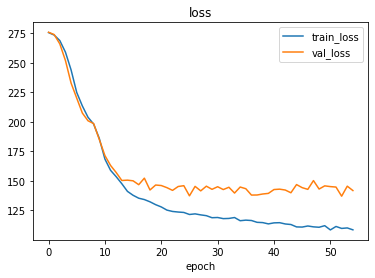

In [58]:
plt.plot(x,loss_train_y,label="train_loss")
plt.plot(x,loss_val_y,label="val_loss")
plt.title("loss")
plt.xlabel('epoch')
plt.legend()
plt.show()

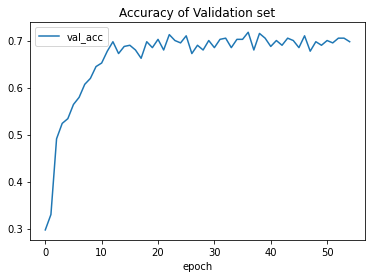

In [59]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.plot(x,acc_val_y,label="val_acc")
plt.title("Accuracy of Validation set")
plt.legend()
plt.xlabel('epoch')
plt.show()